In [ ]:
import time
import json
import random
from string import digits

import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import Normalize, ToTensor, Lambda
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!mkdir dataset
!ls

dataset  sample_data


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use gpu if available
device

device(type='cpu')

In [ ]:
labels = digits
labels

'0123456789'

In [ ]:
train_dataset = datasets.MNIST(
    root='./dataset',
    train=True,
    download=True,
    transform=transforms.Compose([ToTensor(), torch.squeeze, Lambda(lambda x: torch.reshape(x, (-1,)))]),
)

test_dataset = datasets.MNIST(
    root='./dataset',
    train=False,
    download=True,
    transform=transforms.Compose([ToTensor(), torch.squeeze, Lambda(lambda x: torch.reshape(x, (-1,)))]),
)

100%|██████████| 9912422/9912422 [00:00<00:00, 90140756.46it/s]


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 63923848.98it/s]


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43575649.91it/s]


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12508554.67it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [ ]:
train_len, test_len = len(train_dataset), len(test_dataset)

print(f"Тренировочная выборка: {train_len}")
print(f"Тестовая выборка: {test_len}")
print(f"Суммарное количество изображений: {train_len + test_len}")

Тренировочная выборка: 60000
Тестовая выборка: 10000
Суммарное количество изображений: 70000


In [ ]:
print(f"train_dataset[0] = ({type(train_dataset[0][0])}, {type(train_dataset[0][1])})")
print(f"train_dataset[0] = ({train_dataset[0][0].size()}, {train_dataset[0][1]})")

train_dataset[0] = (<class 'torch.Tensor'>, <class 'int'>)
train_dataset[0] = (torch.Size([784]), 5)


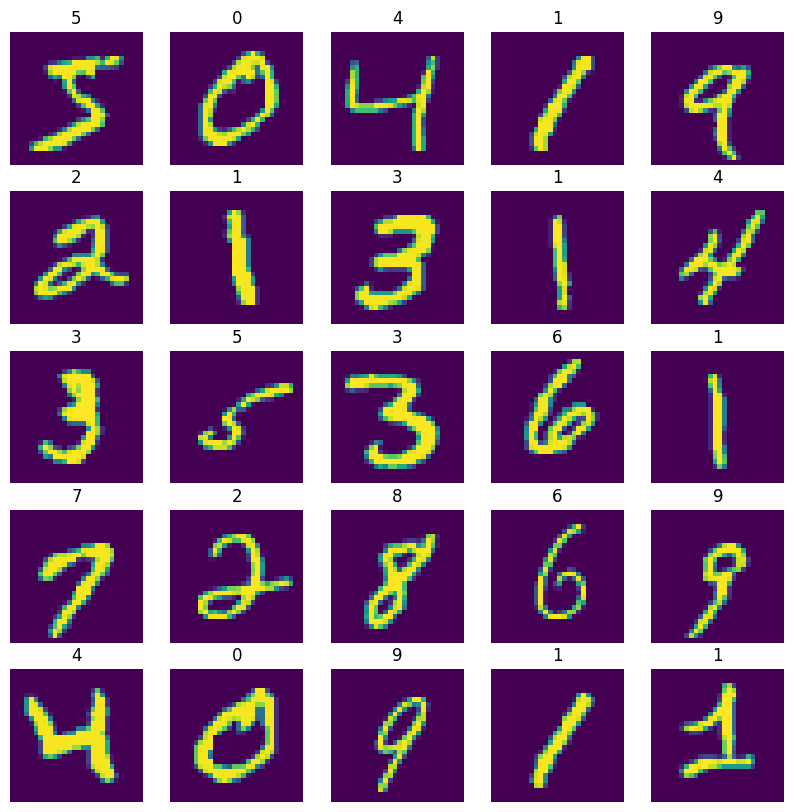

In [ ]:
row, col = 5, 5
fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(10, 10))
for r in range(row):
    for c in range(col):
        img, index = train_dataset[r*row + c]
        ax[r, c].imshow(img.reshape((28, 28)))
        ax[r, c].set_title(f"{index}")
        ax[r, c].set_axis_off()

plt.show()

In [ ]:
from collections import Counter


c = Counter([i[1] for i in train_dataset])
c = sorted(list(dict(c).items()), key=lambda x: x[0])
c

[(0, 5923),
 (1, 6742),
 (2, 5958),
 (3, 6131),
 (4, 5842),
 (5, 5421),
 (6, 5918),
 (7, 6265),
 (8, 5851),
 (9, 5949)]

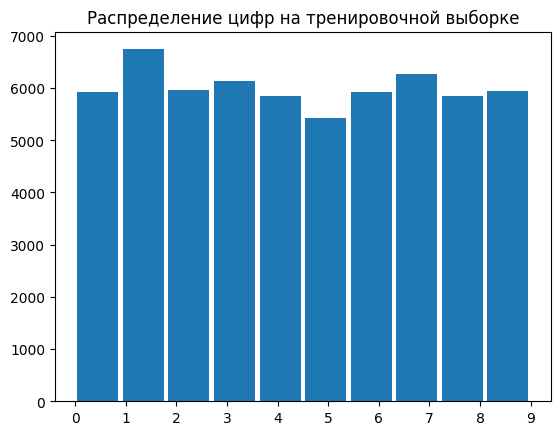

In [ ]:
plt.hist([i[1] for i in train_dataset], rwidth=0.9)
plt.xticks(range(0, 10))
plt.title("Распределение цифр на тренировочной выборке")
plt.show()

In [ ]:
def get_score(
    batch_size,
    num_epoch,
    input_layer,
    hidden_layer,
    output_layer,
    learning_rate,
    loss_fn,
    optimize_fn,
    activation_fn,
    gpu
    ):
    train_dataloader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset,
                                 batch_size=batch_size,
                                 shuffle=False)

    model = nn.Sequential(
          nn.Linear(input_layer, hidden_layer),
          activation_fn(),
          nn.Linear(hidden_layer, output_layer),
        )

    if gpu and torch.cuda.is_available():
        model = model.cuda()
        loss_fn = loss_fn.cuda()

    optimizer = optimize_fn(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(num_epoch):
        for idx, (X, y) in enumerate(train_dataloader):
            if gpu and torch.cuda.is_available():
                X, y = X.cuda(), y.cuda()

            optimizer.zero_grad()

            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()

    all_count = len(test_dataset)
    true_count = 0

    with torch.no_grad():
        model.eval()
        for idx, (X, y) in enumerate(test_dataloader):
            if gpu and torch.cuda.is_available():
                X, y = X.cuda(), y.cuda()
            pred = model(X)
            true_count += (y == torch.argmax(pred, dim=1)).sum()

    percentage = round((true_count / all_count * 100).item(), 3)
    print(f"Процент правильных ответов: {percentage}%")
    return percentage

In [ ]:
hidden_layers = [64, 256, 1024]
batch_sizes = [32, 64, 128]
activation_fns = [nn.ReLU, nn.Sigmoid]
optimizing_fns = [torch.optim.SGD, torch.optim.Adam]
learning_rates = [0.05, 0.1, 0.2]

loss_fn = nn.CrossEntropyLoss()
input_layer = 28*28
output_layer = len(labels)
num_epoch = 5
gpu = False

In [ ]:
start_time = time.perf_counter()


d = {i: [] for i in hidden_layers}
scores = {}

for hidden_layer in hidden_layers:
    for batch_size in batch_sizes:
        for activation_fn in activation_fns:
            for optimize_fn in optimizing_fns:
                for learning_rate in learning_rates:
                    params = {
                        "hidden_layer": hidden_layer,
                        "batch_size": batch_size,
                        "loss_fn": loss_fn,
                        "learning_rate": learning_rate,
                        "optimize_fn": optimize_fn,
                        "activation_fn": activation_fn,
                        "input_layer": input_layer,
                        "output_layer": output_layer,
                        "num_epoch": num_epoch,
                        "gpu": gpu
                    }

                    scores[hidden_layer] = scores.get(hidden_layer, {})
                    next_step = scores[hidden_layer]

                    next_step[batch_size] = next_step.get(batch_size, {})
                    next_step = next_step[batch_size]

                    next_step[activation_fn.__name__] = next_step.get(activation_fn.__name__, {})
                    next_step = next_step[activation_fn.__name__]

                    next_step[optimize_fn.__name__] = next_step.get(optimize_fn.__name__, {})
                    next_step = next_step[optimize_fn.__name__]

                    prediction_score = get_score(**params)
                    next_step[learning_rate] = next_step.get(learning_rate, prediction_score)

                    d[hidden_layer].append(prediction_score)


minutes_to_go = (time.perf_counter() - start_time) // 60
seconds_to_go = (time.perf_counter() - start_time) % 60
print(f"{minutes_to_go} минут, {seconds_to_go} секунд")

In [ ]:
all_scores = np.array(list(d.values())).flatten()
print(all_scores, all_scores.size)

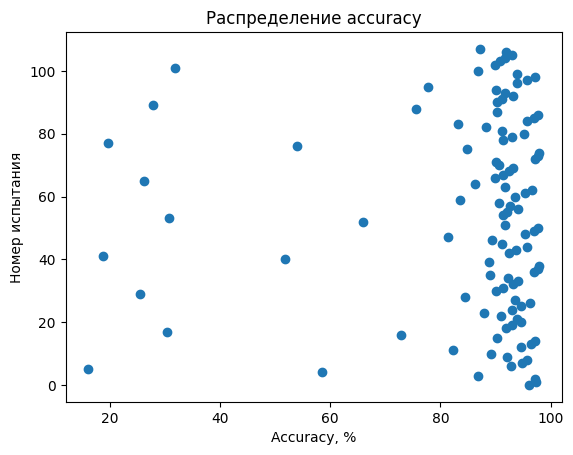

In [ ]:
plt.scatter(y=np.arange(108), x=all_scores)
plt.title("Распределение accuracy")
plt.xlabel("Accuracy, %")
plt.ylabel("Номер испытания")
plt.show()

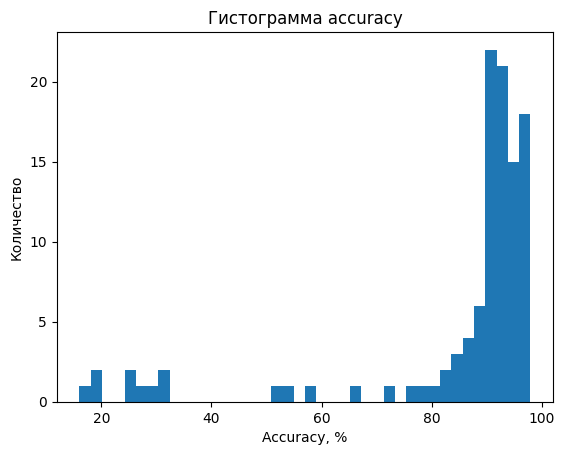

In [ ]:
plt.hist(all_scores, bins=40)
plt.title("Гистограмма accuracy")
plt.xlabel("Accuracy, %")
plt.ylabel("Количество")
plt.show()

In [ ]:
json_dict = json.dumps(
    scores,
    indent=4,
)

print(json_dict)

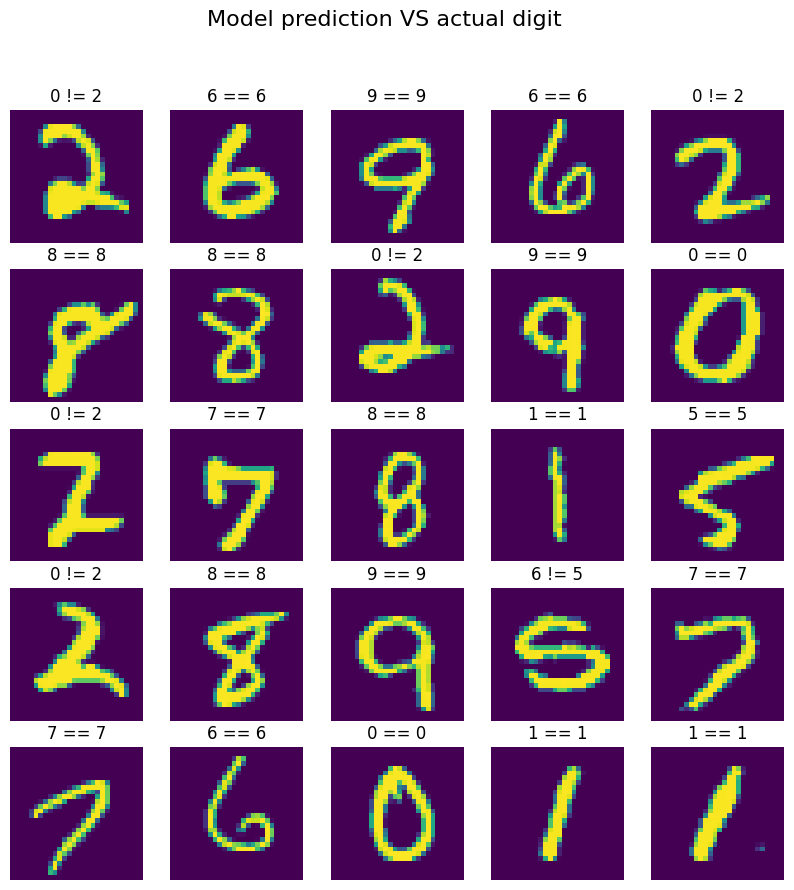

In [ ]:
row, col = 5, 5
fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(10, 10))

for r in range(row):
    for c in range(col):
        idx = random.randint(0, len(test_dataset))
        img, digit = test_dataset[idx]
        model_answer = torch.argmax(model(img), dim=0)

        ax[r, c].imshow(img.reshape((28, 28)))
        if model_answer != digit:
            ax[r, c].set_title(f"{model_answer} != {digit}")
        else:
            ax[r, c].set_title(f"{model_answer} == {digit}")
        ax[r, c].set_axis_off()

fig.suptitle('Model prediction VS actual digit', fontsize=16)
plt.show()